### Env Variables, Seed and Libraries

In [1]:
options(warn = -1)
suppressPackageStartupMessages({
library(caret)
library(dplyr)
library(fastDummies)
library(caTools)
library(randomForest)
library(xgboost)
library(readr)
library(ggplot2)
library(rsample)
})
set.seed(123) 


# Preprocess dataset: Load, clean, encode categorical variables, and separate features and target

In [2]:
# Cell 2: Read the dataset
df <- read_csv("/kaggle/input/mental-health-and-technology-usage-dataset/mental_health_and_technology_usage_2024.csv")
df <- df %>% select(-User_ID)
# Function to convert categorical columns to numeric and store the mapping
convert_to_numeric <- function(data) {
  mappings <- list()
  for (column in names(data)) {
    if (is.factor(data[[column]]) || is.character(data[[column]])) {
      levels <- unique(data[[column]])
      mappings[[column]] <- setNames(seq_along(levels), levels)
      data[[column]] <- as.numeric(factor(data[[column]], levels = levels))
    }
  }
  return(list(data = data, mappings = mappings))
}

# Convert the DataFrame and get mappings
datawithmap <- convert_to_numeric(df)
finaldf <- datawithmap$data
maps <- datawithmap$mappings
print(maps)
head(finaldf,5)

Rows: 10000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): User_ID, Gender, Mental_Health_Status, Stress_Level, Support_System...
dbl (7): Age, Technology_Usage_Hours, Social_Media_Usage_Hours, Gaming_Hours...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


$Gender
Female   Male  Other 
     1      2      3 

$Mental_Health_Status
     Good      Poor      Fair Excellent 
        1         2         3         4 

$Stress_Level
   Low   High Medium 
     1      2      3 

$Support_Systems_Access
 No Yes 
  1   2 

$Work_Environment_Impact
Negative Positive  Neutral 
       1        2        3 

$Online_Support_Usage
Yes  No 
  1   2 



Age,Gender,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Mental_Health_Status,Stress_Level,Sleep_Hours,Physical_Activity_Hours,Support_Systems_Access,Work_Environment_Impact,Online_Support_Usage
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23,1,6.57,6.00,0.68,12.36,1,1,8.01,6.71,1,1,1
21,2,3.01,2.57,3.74,7.61,2,2,7.28,5.88,2,2,2
51,2,3.04,6.14,1.26,3.16,3,2,8.04,9.81,1,1,2
25,1,3.84,4.48,2.59,13.08,4,3,5.62,5.28,2,1,1
53,2,1.20,0.56,0.29,12.63,1,1,5.55,4.00,1,2,1


## Train Test Split

In [3]:
split <- initial_split(finaldf, prop = 0.6)
trainData <- training(split)
testValData <- testing(split)
cat(dim(trainData),dim(testValData))

6000 13 4000 13

## Linear Model Fit

In [4]:
linearmodel <- lm(Sleep_Hours ~ ., data = trainData)
summary(linearmodel)


Call:
lm(formula = Sleep_Hours ~ ., data = trainData)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5865 -1.2396 -0.0219  1.2603  2.6264 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6.5539029  0.1530168  42.831   <2e-16 ***
Age                      -0.0005941  0.0013644  -0.435   0.6633    
Gender                   -0.0183932  0.0229044  -0.803   0.4220    
Technology_Usage_Hours   -0.0029889  0.0059579  -0.502   0.6159    
Social_Media_Usage_Hours  0.0039942  0.0081133   0.492   0.6225    
Gaming_Hours              0.0069306  0.0130529   0.531   0.5955    
Screen_Time_Hours        -0.0005340  0.0046451  -0.115   0.9085    
Mental_Health_Status     -0.0110697  0.0168084  -0.659   0.5102    
Stress_Level              0.0143562  0.0229134   0.627   0.5310    
Physical_Activity_Hours  -0.0046808  0.0064803  -0.722   0.4701    
Support_Systems_Access    0.0108625  0.0375942   0.289   0.7726    
Work_Environment_Imp

## Display Sample Predictions of Linear model

In [5]:
X_test <- testValData %>% select(-Sleep_Hours)

predictions <- predict(linearmodel, newdata = X_test)

actuals <- testValData$Sleep_Hours

mae <- mean(abs(predictions - actuals))
mse <- mean((predictions - actuals)^2)
rmse <- sqrt(mse)

cat("Mean Absolute Error (MAE):", mae, "\n")
cat("Mean Squared Error (MSE):", mse, "\n")
cat("Root Mean Squared Error (RMSE):", rmse, "\n")

results_df <- data.frame(
  `Actual Sleep Hours` = actuals,
  `Predicted Sleep Hours` = predictions
)

print(head(results_df))

Mean Absolute Error (MAE): 1.254044 
Mean Squared Error (MSE): 2.094947 
Root Mean Squared Error (RMSE): 1.447393 
  Actual.Sleep.Hours Predicted.Sleep.Hours
1               7.28              6.555261
2               8.04              6.538923
3               8.61              6.400705
4               8.61              6.517717
5               7.11              6.508744
6               5.09              6.518094


# Decision Trees

## KFold Cross Validation

In [6]:
data <- finaldf
target <- data$Sleep_Hours
features <- data[, setdiff(names(data), "Sleep_Hours")]
# Set up K-fold cross-validation (5 folds)
k_folds <- 5
train_control <- trainControl(method = "cv", number = k_folds)

## Find best mtry value with Random Forest Model

In [7]:
# Train the Random Forest model with K-fold cross-validation using x and y interface
rf_model <- train(
  x = features,
  y = target,
  method = "rf",
  trControl = train_control,
  tuneLength = 3
)

# Display the results
print(rf_model)

Random Forest 

10000 samples
   12 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 8000, 7999, 8001, 8000, 8000 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared      MAE     
   2    1.463439  0.0019676966  1.266121
   7    1.470097  0.0010253140  1.271171
  12    1.471346  0.0009208063  1.271556

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.


## Define Param Grid and find best combination of Hyper Params with mtry set

Current parameters: ntree=450, nodesize=15, maxnodes=50

Best parameter combination:
  ntree nodesize maxnodes     RMSE      MAE     Rsquared
4    50       10       20 1.451307 1.259001 0.0001024091

Top 10 parameter combinations:
   ntree nodesize maxnodes     RMSE      MAE     Rsquared
4     50       10       20 1.451307 1.259001 0.0001024091
7     50       15       20 1.451337 1.259424 0.0004923137
43   450       15       20 1.451385 1.259375 0.0002028729
34   350       15       20 1.451520 1.259394 0.0001579377
38   450        5       30 1.451524 1.259499 0.0011173030
22   250       10       20 1.451525 1.259283 0.0005232192
40   450       10       20 1.451573 1.259521 0.0001494893
19   250        5       20 1.451591 1.259510 0.0002374021
41   450       10       30 1.451674 1.259245 0.0001000566
1     50        5       20 1.451723 1.259676 0.0003407868


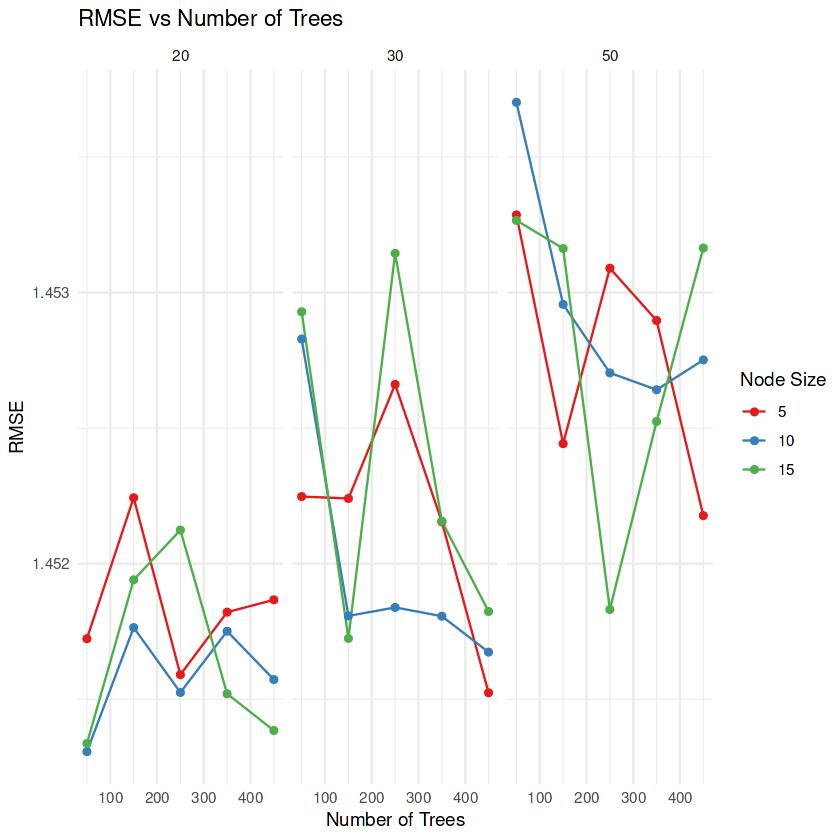

In [9]:
# Prepare the data and convert to data.frame if it's a tibble
data <- as.data.frame(finaldf)
target <- data$Sleep_Hours
features <- as.data.frame(data[, setdiff(names(data), "Sleep_Hours")])

# Set up parameters to test
ntree_values <- seq(50, 500, by = 100)
nodesize_values <- c(5, 10, 15)
maxnodes_values <- c(20, 30, 50)

# Calculate total number of iterations for progress bar
total_iterations <- length(ntree_values) * length(nodesize_values) * length(maxnodes_values)
current_iteration <- 0

# Initialize results storage
results <- data.frame()

k_folds <- 5
train_control <- trainControl(method = "cv", 
                            number = k_folds,
                            verbose = FALSE)  # Set to FALSE to avoid additional output

# Nested loops to try all combinations
for(ntree in ntree_values) {
  for(nodesize in nodesize_values) {
    for(maxnodes in maxnodes_values) {
      
      # Create tuning grid with current nodesize and maxnodes
      tune_grid <- data.frame(mtry = 2)  # Keep optimal mtry
      
      # Train model with current parameters
      rf_model <- train(
        x = features,
        y = target,
        method = "rf",
        trControl = train_control,
        tuneGrid = tune_grid,
        ntree = ntree,
        nodesize = nodesize,
        maxnodes = maxnodes
      )
      
      # Store results
      current_result <- data.frame(
        ntree = ntree,
        nodesize = nodesize,
        maxnodes = maxnodes,
        RMSE = min(rf_model$results$RMSE),
        MAE = min(rf_model$results$MAE),
        Rsquared = max(rf_model$results$Rsquared)
      )
      
      results <- rbind(results, current_result)
      
      
      # Print current parameters (optional)
      cat(sprintf("\rCurrent parameters: ntree=%d, nodesize=%d, maxnodes=%d", 
                  ntree, nodesize, maxnodes))
    }
  }
}

# Clear the last printed line
cat("\n")

# Find the best combination of parameters
best_params <- results[which.min(results$RMSE), ]
cat("\nBest parameter combination:\n")
print(best_params)

# Plot results using ggplot2
library(ggplot2)

# Plot RMSE vs ntree for different nodesize values
p <- ggplot(results, aes(x = ntree, y = RMSE, color = factor(nodesize))) +
  geom_line() +
  geom_point() +  # Added points for better visibility
  facet_wrap(~maxnodes) +
  labs(title = "RMSE vs Number of Trees",
       x = "Number of Trees",
       y = "RMSE",
       color = "Node Size") +
  theme_minimal() +
  scale_color_brewer(palette = "Set1")  # Better color scheme

print(p)

# Create a summary table of top 10 best combinations
cat("\nTop 10 parameter combinations:\n")
top_10 <- results[order(results$RMSE), ][1:10, ]
print(top_10)

## Ensemble approach (stacking multiple models)

In [10]:
# Load required libraries
library(caret)
library(randomForest)
library(xgboost)
library(gbm)
library(doParallel)

# Set up parallel processing
num_cores <- detectCores() - 1
cl <- makeCluster(num_cores)
registerDoParallel(cl)

# Prepare the data
data <- as.data.frame(finaldf)
target <- data$Sleep_Hours
features <- as.data.frame(data[, setdiff(names(data), "Sleep_Hours")])

# Create training control - removed repeats parameter
train_control <- trainControl(
    method = "cv",
    number = 5,
    savePredictions = TRUE,
    verboseIter = FALSE
)

# Correctly specify RF grid with only mtry
rf_grid <- data.frame(mtry = 2)  # Best value from previous tuning

# Simplified grids for other models
xgb_grid <- expand.grid(
    nrounds = c(100, 200),
    max_depth = c(3, 6),
    eta = 0.1,
    gamma = 0,
    colsample_bytree = 0.8,
    min_child_weight = 1,
    subsample = 0.8
)

gbm_grid <- expand.grid(
    n.trees = c(100, 200),
    interaction.depth = c(3, 5),
    shrinkage = 0.1,
    n.minobsinnode = 10
)

# Create progress bar
cat("\nTraining Models:\n")

# Train models
models_list <- list()

# 1. Random Forest with pre-tuned parameters
cat("\nTraining Random Forest...\n")
rf_model <- randomForest(
    x = features,
    y = target,
    ntree = 350,
    mtry = 2,
    nodesize = 15,
    maxnodes = 20
)
models_list[["RF"]] <- rf_model

# 2. XGBoost
cat("\nTraining XGBoost...\n")
xgb_model <- train(
    x = features,
    y = target,
    method = "xgbTree",
    trControl = train_control,
    tuneGrid = xgb_grid,
    verbose = FALSE
)
models_list[["XGB"]] <- xgb_model

# 3. GBM
cat("\nTraining GBM...\n")
gbm_model <- train(
    x = features,
    y = target,
    method = "gbm",
    trControl = train_control,
    tuneGrid = gbm_grid,
    verbose = FALSE
)
models_list[["GBM"]] <- gbm_model

# Create ensemble predictions
predictions_rf <- predict(rf_model, newdata = features)
predictions_xgb <- predict(xgb_model, newdata = features)
predictions_gbm <- predict(gbm_model, newdata = features)

# Simple average ensemble
ensemble_predictions <- (predictions_rf + predictions_xgb + predictions_gbm) / 3

# Calculate performance metrics
rf_rmse <- sqrt(mean((predictions_rf - target)^2))
xgb_rmse <- sqrt(mean((predictions_xgb - target)^2))
gbm_rmse <- sqrt(mean((predictions_gbm - target)^2))
ensemble_rmse <- sqrt(mean((ensemble_predictions - target)^2))

# Print results
cat("\nModel Performance (RMSE):\n")
cat("Random Forest:", rf_rmse, "\n")
cat("XGBoost:", xgb_rmse, "\n")
cat("GBM:", gbm_rmse, "\n")
cat("Ensemble:", ensemble_rmse, "\n")

# Stop parallel processing
stopCluster(cl)

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel




Training Models:

Training Random Forest...

Training XGBoost...

Training GBM...

Model Performance (RMSE):
Random Forest: 1.440298 
XGBoost: 1.412972 
GBM: 1.430844 
Ensemble: 1.426808 


## XGBoost Alone (Best)

[1]	train-rmse:5.882122+0.002315	test-rmse:5.882115+0.008442 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 50 rounds.

[51]	train-rmse:1.377400+0.008041	test-rmse:1.533432+0.008230 
[101]	train-rmse:1.139390+0.010567	test-rmse:1.480954+0.010503 
Stopping. Best iteration:
[81]	train-rmse:1.203838+0.009360	test-rmse:1.478304+0.009593


Model Performance:
RMSE: 1.241005 
MAE: 1.065648 
Optimal number of rounds: 81 
                     Feature       Gain       Cover  Frequency
                      <char>      <num>       <num>      <num>
 1:        Screen_Time_Hours 0.16192366 0.163671111 0.15431082
 2: Social_Media_Usage_Hours 0.16170120 0.161588030 0.15310269
 3:             Gaming_Hours 0.15156660 0.186156100 0.14486546
 4:   Technology_Usage_Hours 0.14820446 0.156595317 0.14168040
 5:  Physical_Activity_Hours 0.13952011 0.152542523 0.13102691
 6:                      Age 0.10705240 0.101229761 0.11718836
 7:  

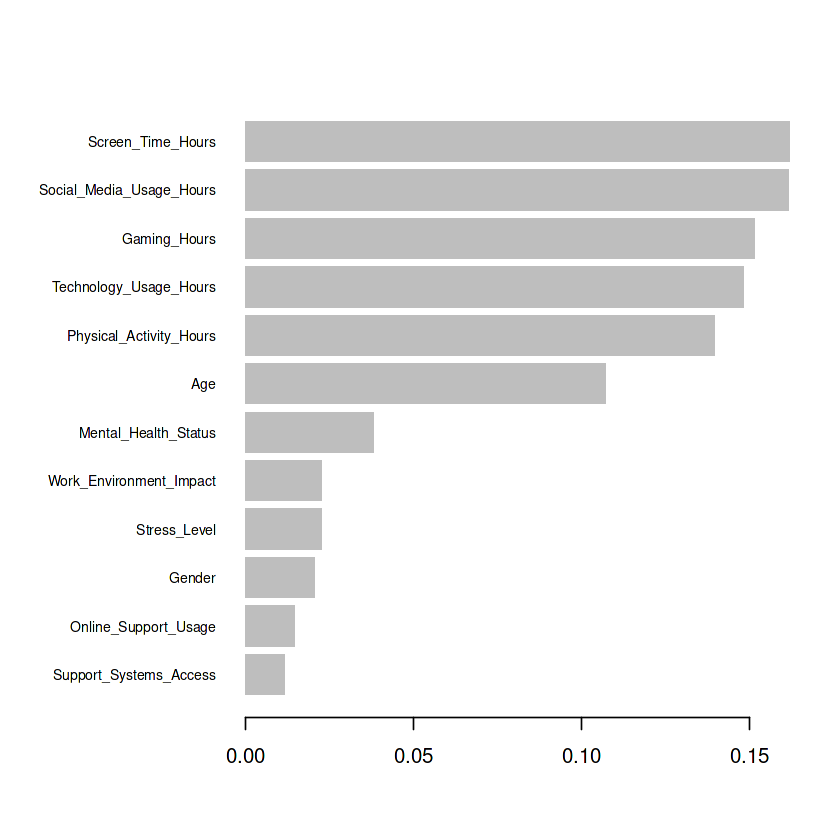

In [11]:
# Load libraries
library(xgboost)
library(dplyr)

# Data preparation and cleaning
data <- as.data.frame(finaldf)

# Replace infinite values with NA and then remove rows with NA
data <- data %>%
  mutate_all(function(x) ifelse(is.infinite(x), NA, x)) %>%
  na.omit()

# Separate features and target
target <- data$Sleep_Hours
features <- data %>% select(-Sleep_Hours)

# Convert categorical variables to numeric if any
categorical_vars <- c("Gender", "Mental_Health_Status", "Work_Environment_Impact")
features[categorical_vars] <- lapply(features[categorical_vars], as.numeric)

# Convert to matrix and check for any remaining inf/nan
features_matrix <- as.matrix(features)
if(any(is.infinite(features_matrix)) || any(is.nan(features_matrix))) {
    stop("Matrix still contains inf or nan values")
}

# Create DMatrix
dtrain <- xgb.DMatrix(data = features_matrix, label = target)

# Parameters
params <- list(
    objective = "reg:squarederror",
    eval_metric = "rmse",
    tree_method = "hist",
    max_depth = 8,
    eta = 0.05,
    subsample = 0.85,
    colsample_bytree = 0.85,
    min_child_weight = 2,
    gamma = 0.1
)

# Cross-validation with early stopping
cv_results <- xgb.cv(
    params = params,
    data = dtrain,
    nrounds = 1000,
    nfold = 5,
    early_stopping_rounds = 50,
    print_every_n = 50,
    verbose = 1
)

# Train final model
optimal_nrounds <- which.min(cv_results$evaluation_log$test_rmse_mean)
xgb_model <- xgb.train(
    params = params,
    data = dtrain,
    nrounds = optimal_nrounds,
    verbose = 1
)

# Make predictions and calculate metrics
predictions <- predict(xgb_model, dtrain)
rmse <- sqrt(mean((predictions - target)^2))
mae <- mean(abs(predictions - target))

# Print results
cat("\nModel Performance:\n")
cat("RMSE:", rmse, "\n")
cat("MAE:", mae, "\n")
cat("Optimal number of rounds:", optimal_nrounds, "\n")

# Feature importance
importance_matrix <- xgb.importance(feature_names = colnames(features), model = xgb_model)
print(importance_matrix)

# Plot feature importance
xgb.plot.importance(importance_matrix, top_n = 15)

# Scale features, apply PCA (95% variance), and split data into training and testing sets

In [12]:
# Separate features and target variable
features <- finaldf %>% select(-Sleep_Hours)  # All columns except Sleep_Hours
target <- finaldf$Sleep_Hours                 # Target variable (Sleep_Hours)

# Apply scaling to features before Linear/Polynomial Regression
scaled_features <- scale(features)

# Apply PCA using caret's preProcess function (retain enough components to explain 95% variance)
pca_model <- preProcess(scaled_features, method = "pca", thresh = 0.95)

# Transform scaled features using PCA
features_pca <- predict(pca_model, scaled_features)

# Combine transformed features with target variable for further modeling
data_pca <- data.frame(features_pca, Sleep_Hours = target)

# Split data into training (60%) and testing (40%) sets using caTools package
split <- sample.split(data_pca$Sleep_Hours, SplitRatio = 0.6)
train_data <- subset(data_pca, split == TRUE)
test_data <- subset(data_pca, split == FALSE)

# Fit linear model to the newly derived features by PCA

In [13]:
# Train a linear regression model on scaled principal components
linear_model <- lm(Sleep_Hours ~ ., data = train_data)

# Predict on test data using linear regression model
linear_preds <- predict(linear_model, newdata = test_data)

# Calculate RMSE for linear regression model on test set
linear_rmse <- sqrt(mean((test_data$Sleep_Hours - linear_preds)^2))
print(paste("Linear Regression RMSE after PCA with scaling:", linear_rmse))

[1] "Linear Regression RMSE after PCA with scaling: 1.45154120479356"


# RF Model with PCA features

[1] "Random Forest RMSE after PCA: 1.45051301428582"


,IncNodePurity
PC1,35.21610
PC2,28.76795
PC3,32.69813
PC4,37.48027
PC5,35.82720
PC6,32.57980
PC7,35.23435
PC8,27.30887
PC9,33.85461
PC10,35.30125


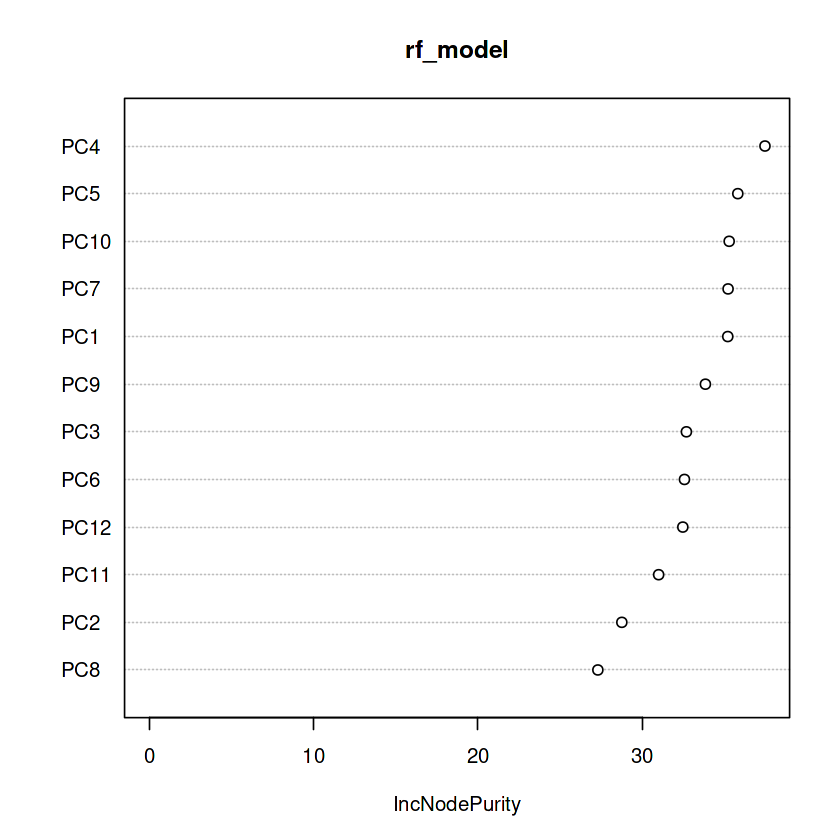

In [14]:
# Train a Random Forest model with tuned hyperparameters after PCA (no scaling needed for RF)
rf_model <- randomForest(
    x = train_data %>% select(-Sleep_Hours),
    y = train_data$Sleep_Hours,
    ntree = 350,
    mtry = 2,
    nodesize = 15,
    maxnodes = 20
)

# Predict on test data using Random Forest model
rf_preds <- predict(rf_model, newdata = test_data %>% select(-Sleep_Hours))

# Calculate RMSE for Random Forest model on test set
rf_rmse <- sqrt(mean((test_data$Sleep_Hours - rf_preds)^2))
print(paste("Random Forest RMSE after PCA:", rf_rmse))

# View feature importance in Random Forest model (after PCA)
importance(rf_model)
varImpPlot(rf_model)

## Contribution to PCs by true column features

In [15]:
print(pca_model$rotation)

                                 PC1         PC2         PC3         PC4
Age                       0.14397251  0.47369101  0.21420128 -0.28055012
Gender                   -0.03995415 -0.33295360 -0.15562827 -0.29620536
Technology_Usage_Hours    0.43898371  0.35093697 -0.19833247 -0.03880952
Social_Media_Usage_Hours  0.12653774  0.31140342 -0.42389454 -0.11073880
Gaming_Hours              0.05831314  0.31217427 -0.18443189 -0.13810135
Screen_Time_Hours         0.39866761 -0.02183234  0.37704035  0.43488329
Mental_Health_Status     -0.21761522  0.04256622 -0.05276580 -0.13264706
Stress_Level             -0.03762543 -0.33170295 -0.22881762 -0.34881635
Physical_Activity_Hours   0.51702997 -0.23856407 -0.04965506  0.15054159
Support_Systems_Access    0.35750241 -0.35776457  0.30237829 -0.40277007
Work_Environment_Impact  -0.01383483 -0.20122402 -0.50550776  0.50319593
Online_Support_Usage      0.40314931 -0.09727443 -0.36072520 -0.18500963
                                 PC5          PC6  

# XGBoost with PC features

[1]	train-rmse:5.883031+0.003464	test-rmse:5.883006+0.014203 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 50 rounds.

[51]	train-rmse:1.318635+0.007327	test-rmse:1.538964+0.022395 
[101]	train-rmse:1.023208+0.015553	test-rmse:1.488615+0.023449 
Stopping. Best iteration:
[80]	train-rmse:1.110771+0.015206	test-rmse:1.484245+0.022518

[1] "XGBoost RMSE after PCA: 1.47191494792884"
    Feature       Gain      Cover  Frequency
     <char>      <num>      <num>      <num>
 1:     PC1 0.09909443 0.07550111 0.10717004
 2:     PC4 0.09016690 0.11571541 0.09346933
 3:     PC7 0.09000852 0.11626830 0.08890242
 4:    PC10 0.08790530 0.07311808 0.08311767
 5:     PC8 0.08737000 0.08390742 0.08022530
 6:     PC6 0.08286829 0.07890278 0.08007307
 7:    PC12 0.08167177 0.07841632 0.07946415
 8:     PC3 0.08095993 0.07791235 0.08235652
 9:    PC11 0.07903179 0.07692049 0.07413609
10:     PC9 0.07605811 0.06718051 0.07291825
11:

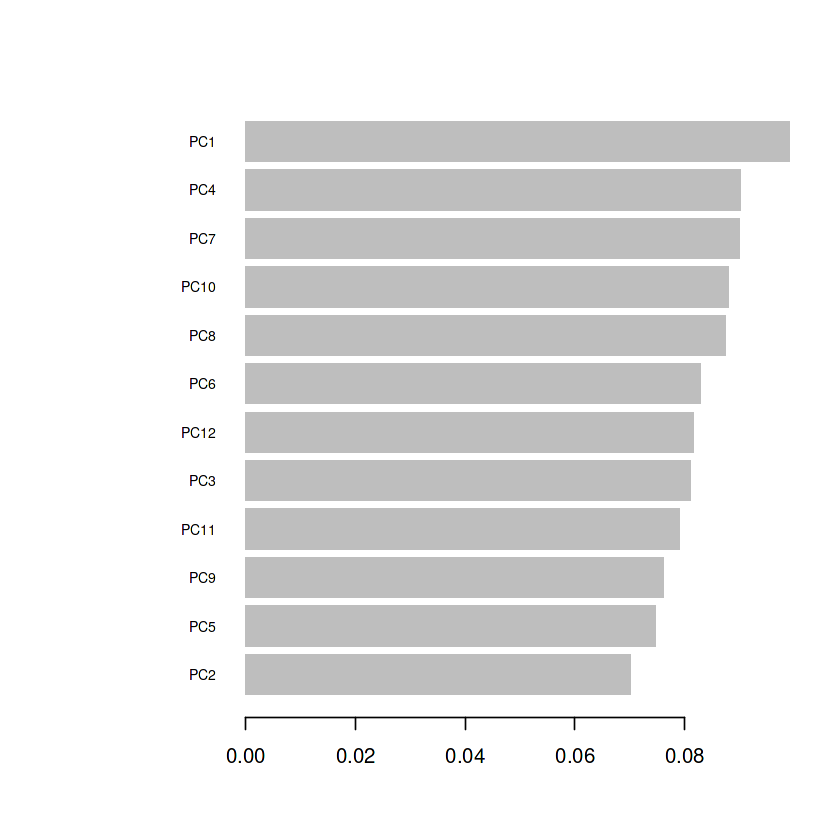

In [16]:
# Prepare data for xgboost (convert to matrix format as required by xgboost)
train_matrix <- as.matrix(train_data %>% select(-Sleep_Hours))
train_label <- train_data$Sleep_Hours

test_matrix <- as.matrix(test_data %>% select(-Sleep_Hours))
test_label <- test_data$Sleep_Hours

dtrain <- xgb.DMatrix(data = train_matrix, label = train_label)
dtest <- xgb.DMatrix(data = test_matrix, label = test_label)

params <- list(
    objective = "reg:squarederror",
    eval_metric = "rmse",
    tree_method = "hist",
    max_depth = 8,
    eta = 0.05,
    subsample = 0.85,
    colsample_bytree = 0.85,
    min_child_weight = 2,
    gamma = 0.1
)

# Cross-validation with early stopping to find optimal number of rounds
cv_results <- xgb.cv(
    params = params,
    data = dtrain,
    nrounds = 1000,
    nfold = 5,
    early_stopping_rounds = 50,
    print_every_n = 50,
    verbose = TRUE
)

optimal_nrounds <- which.min(cv_results$evaluation_log$test_rmse_mean)

# Train final XGBoost model with optimal number of rounds from cross-validation
xgb_model <- xgb.train(
    params = params,
    data = dtrain,
    nrounds = optimal_nrounds,
    verbose = TRUE
)

# Predict on test data using XGBoost model
xgb_preds <- predict(xgb_model, newdata = dtest)

# Calculate RMSE for XGBoost model on test set
xgb_rmse <- sqrt(mean((test_label - xgb_preds)^2))
print(paste("XGBoost RMSE after PCA:", xgb_rmse))

# View feature importance in XGBoost model (after PCA)
importance_matrix <- xgb.importance(model=xgb_model)
print(importance_matrix)
xgb.plot.importance(importance_matrix)

# Conclusion

In [20]:
print(paste("Linear Regression RMSE after PCA with scaling:", linear_rmse))
print(paste("Random Forest RMSE after PCA:", rf_rmse))
print(paste("XGBoost RMSE after PCA:", xgb_rmse))

best_model_name <- switch(which.min(c(linear_rmse, rf_rmse, xgb_rmse)),
                          "Linear Regression",
                          "Random Forest",
                          "XGBoost")

print(paste("Best Model After PCA is:", best_model_name))

[1] "Linear Regression RMSE after PCA with scaling: 1.45154120479356"
[1] "Random Forest RMSE after PCA: 1.45051301428582"
[1] "XGBoost RMSE after PCA: 1.47191494792884"
[1] "Best Model After PCA is: Random Forest"


# The highest achieved RMSE is by XGBoost with finetuned Hyperparams. RMSE : 1.241005